In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy.integrate import quad,dblquad,nquad
from scipy.optimize import root_scalar
from timeit import default_timer as timer
import vegas
#import quadpy

In [2]:
# Global constants
# light speed, cm
c = 3*1e10
# kpc to cm
kpc2cm = 3.08*1e21
# erg to MeV
erg2MeV = 624150.913
# year in seconds
yr = 31536000
# Neutrino lumonisity, single specie
Lv = 3e52/6

## SN neutrino and DM halo profile
The neutrino number density per energy
$$
\frac{dn_\nu}{dE_\nu}(r,E_\nu) = \sum_\beta \frac{L_{\nu_{\beta}}}{4\pi r^2 c \langle E_{\nu_\beta}\rangle}f_{\nu_\beta}(E_{\nu_\beta})
$$
where $\beta$ indicates the neutrino flavor and
$$
f_{\nu_\beta}(E_{\nu_\beta}) = \frac{1}{F_2(\eta_\nu)}\frac{1}{T_{\nu_\beta}^3}\frac{E_{\nu_\beta}^2}{\exp(E_{\nu_\beta}/T_{\nu_\beta} -\eta_\nu)+1}
$$
and in general $\eta_\nu=3$ for all flavor $\beta$ and $F_2(\eta_\nu)\approx 18.96$.

NFW DM density profile
$$
n_\chi(r)=\frac{\rho_\chi}{m_\chi}\frac{1}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}
$$
where $\rho_\chi = 184\,{\rm MeV/cm}^3$ and $r_s=24.42\,{\rm kpc}$.

In [3]:
def dnvdEv(r,Ev,Lv=Lv):
    """
    Neutrino number density per energy at r
    
    Input
    ------
    Enu: Neutrino energy in MeV
    r: Distance to the SN explosion site, in kpc
    Lv: Neutrino luminosity, default is 1e52 erg/s, total time is 10 second
    
    Output
    ------
    Neutrino flux at r: # per Enu per cm**3 per second
    """
    Lv = Lv*erg2MeV
    r = r*kpc2cm
    
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        return (1/18.9686)*(1/Tv**3)*(Ev**2/(np.exp(Ev/Tv - 3)+1))
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    L=Lv/(4*np.pi*r**2*c)
    return L*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx,rho=184,rs=24.42):
    """
    DM number density at r
    
    Input
    ------
    r: distance to GC, in kpc
    mx: DM mass in MeV
    rho: characteristic density, default is 184 MeV/cm^3
    rs: characteristic length, default is 24.42 kpc
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    #rs = rs*kpc2cm
    rr=r/rs
    return (rho/mx)/(rr*(1+rr)**2)

## DM emissivity

Upscattered DM emissivity
$$
j_\chi^N(r,p_\chi,\alpha)=\frac{dn_\chi}{dtdp_\chi d\Omega_\alpha}=\frac{dn_\chi}{dtdE_\nu d\Omega_\alpha}\frac{dE_\nu}{dp_\chi}=c\sigma_{\chi \nu}n_\chi(r)\frac{dn_\nu}{dE_\nu}g(\alpha,E_\nu)\frac{dE_\nu}{dp_\chi},
$$
where $g(\alpha,E_\nu)$ is the angular distribution of the upscattered DM, $p$ the upscattered DM momentum and $\alpha$ the scattering angle.

The angluar distribution is given by
$$
g(\alpha,E_\nu)=\frac{dn_\chi}{d\Omega_\alpha}=\frac{\sin[2\tan^{-1}(\gamma \tan\alpha)]}{2\pi \sin\alpha}\frac{\gamma \sec^2\alpha}{1+\gamma^2\tan^2\alpha}=\frac{\gamma^2}{\pi}\frac{\sec^3\alpha}{(1+\gamma^2\tan^2\alpha)^2} = \frac{\gamma^2}{\pi}\frac{r^3\sqrt{r^2-R^2\sin^2\theta}}{(r^2+R^2(\gamma^2-1)\sin^2\theta)^2}
$$
and satisfies the normalization condiation
$$
\int g(\alpha,E_\nu)d\cos\alpha d\phi =1
$$
where $\alpha$ runs from $0$ to $\pi/2$ and $\gamma=E_\chi/m_\chi$. As a matter of fact, the above condition is irrelevant to $\gamma$.

### Find $E_\nu$ with given $T_\chi$ and $\alpha$

We re-express $p_\chi$ in terms of kinetic energy $T_\chi$ via
$$
p_\chi = \sqrt{T_\chi(T_\chi+2m_\chi)}\to dp_\chi = \frac{T_\chi + m_\chi}{\sqrt{T_\chi(T_\chi+2m_\chi)}}dT_\chi \equiv \frac{dT_\chi}{v_\chi(T_\chi,m_\chi)}
$$
thus
$$
\frac{dE_\nu}{dp_\chi}= v_\chi(T_\chi,m_\chi)\frac{dE_\nu}{dT_\chi}\quad {\rm and}\quad \frac{dE_\nu}{dp_\chi}dp_\chi=\frac{dE_\nu}{dT_\chi}dT_\chi.
$$
In the limits of non-relativistic $T_\chi \ll m_\chi$ and of relativistic $T_\chi \gg m_\chi$, they have $v_\chi\to \sqrt{2T_\chi/m_\chi}$ and $v_\chi \to 1$ respectively as expected. Note that the relation between $E_\nu$ and $T_\chi$ can be determined by
$$
T_\chi = \frac{E_\nu^2}{E_\nu+m_\chi/2}\left(\frac{1+\cos\theta_c}{2}\right)
$$
and
$$
\theta_c = 2\tan^{-1}(\gamma \tan\alpha)
$$
where $\gamma = E_{\chi,{\rm cm}}/m_\chi$. Once $\alpha$ and $T_\chi$ are given, $E_\nu$ will be specified, hence numerically we have
$$
\frac{dE_\nu}{dT_\chi} =\underset{dT_{\chi}\to 0}{\lim} \frac{E_\nu(T_\chi+dT_\chi,\alpha)-E_\nu(T_\chi,\alpha)}{dT_\chi}.
$$
We can obtain $E_\nu$ with given $T_\chi$ and $\alpha$ through *root finding method*.

An alternative way is to derive the *analytical expression* of $E_\nu$ in terms of $T_\chi$,
$$
E_{\nu}=\frac{T_{\chi}\sec^{2}\alpha+\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}{2-T_{\chi}\tan^{2}\alpha/m_{\chi}}=\frac{T_{\chi}m_{\chi}}{\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})\left(1-\frac{R^{2}}{r^{2}}\sin^{2}\theta\right)}-T_{\chi}}
$$
where $\gamma$ can be expressed in terms fo $E_\nu$ and $m_\chi$ by
$$
\gamma=\frac{E_{\chi,{\rm cm}}}{m_\chi}=\frac{s+m_\chi^2}{2\sqrt{s}}\frac{1}{m_\chi}=\frac{E_\nu +m_\chi}{\sqrt{m_\chi(2E_\nu + m_\chi)}}.
$$
It is obvious that the numerator of $E_\nu$ is always positive but the denominator is not when $2<T_\chi \tan^2\alpha/m_\chi$. Thus $E_\nu$ will turn negative and becomes unphysical. For the given $\alpha$ and $m_\chi$, the allowed range is $T_\chi < 2m_\chi/\tan^2\alpha$. There is another root for $E_\nu$ but it is always negative.

Thus we have the differential
$$
\frac{dE_\nu}{dT_\chi}= \frac{m_{\chi}^{2}\sec\alpha(2\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}+2m_{\chi}+T_{\chi}\sec^{2}\alpha+T_{\chi})}{(T_{\chi}\tan^{2}\alpha-2m_{\chi})^2\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}=\frac{m_{\chi}^{2}\left(\frac{2\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}}{\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}}+2m_{\chi}+\frac{T_{\chi}}{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}+2T_{\chi}\right)}{\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}\left(\frac{R^{2}\sin^{2}\theta T_{\chi}}{r^{2}-R^{2}\sin^{2}\theta}-2m_{\chi}\right){}^{2}}
$$
No matter it is through root finding or analytical expression, both results should agree with each other.

In [4]:
def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """
    if 0 <= alpha <= np.pi/2 and Ev>0: 
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
        return dndOmega
    else:
        return 0

    
def g_theta(Ev,mx,theta,r,R=8.5):
    """
    Calculate BDM angular distribution
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """
    if Ev>0: 
        gm = gamma(Ev,mx)
        numerator = gm**2*r**3*np.sqrt(r**2-R**2*np.sin(theta)**2)
        denominator = np.pi*(r**2+R**2*(gm**2-1)*np.sin(theta)**2)**2
        return numerator/denominator
    else:
        return 0


def Tx(Ev,mx,alpha):
    """
    Calculate DM kinetic energy, Eq. (28), and velocity, Eq. (30),
    in terms of lab frame scattering angle
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    Tx: DM kinetic energy at alpha after scattering
    """
    # gamma factor in CM frame
    gm = gamma(Ev,mx)
    # CM frame scattering angle
    theta_c = 2*np.arctan(gm*np.tan(alpha))
    
    # Tmax in lab frame
    Tmax = Ev**2/(Ev+0.5*mx)
    Tchi = 0.5*Tmax*(1+np.cos(theta_c))
    return Tchi


def Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame scattering angle alpha via analytical expression.
    Note that if Ev is negative then it is unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """
    sec = 1/np.cos(alpha)
    enu = (Tx*sec**2 + sec*np.sqrt(Tx*(2*mx + Tx)))/(2 - Tx*np.tan(alpha)**2/mx)
    return enu


def Ev_theta(Tx,mx,theta,r,R=8.5):
    """
    Calculate the neutrino energy to produce DM kinetic energy with
    open angle theta at Earth via analytical expression.
    Note that if Ev is negative then it is unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    theta: open angle
    r: the upscattering point in kpc
    R: the distance between Earth and the SN explosion site, in kpc
    
    Output
    Ev: the corresponding neutrino energy
    """
    denominator = -Tx + np.sqrt(Tx*(2*mx+Tx)*(1-R**2*np.sin(theta)**2/r**2))
    return mx*Tx/denominator


def dEvdTx(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def dEvdTx_theta(Tx,mx,theta,r,R=8.5):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    theta: open angle
    r: the upscattering point in kpc
    R: the distance between Earth and the SN explosion site, in kpc
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    factor1 = np.sqrt(1 - (R*np.sin(theta)/r)**2)
    factor2 = np.sqrt(Tx*(2*mx+Tx))
    numerator = (2*(mx+Tx) + Tx/factor1**2 + 2*factor2/factor1)*mx**2
    denominator = factor1*factor2*(-2*mx + R**2*np.sin(theta)**2*Tx/(r**2-R**2*np.sin(theta)**2))**2
    return numerator/denominator


def vx(Tx,mx):
    """
    The dimensionless DM velocity. To restore the physical unit, just
    times the speed of light c
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    
    Output
    ------
    vx: dimensionless DM velocity
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)


def xemissivity(Tx,mx,alpha,r,rho=184,rs=24.42,Lv=Lv):
    """
    Upscattered DM emissivity, note the returned result is divided by sigxv and light velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    vx: the DM dimensionless velocity in terms of Tx and mx
    r: the distance from the scattering point to GC, kpc
    rho: DM halo characteristic density, default 184 MeV/cm^3
    rs: DM halo characteristic length, default 24.42 kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    Enu = Ev(Tx,mx,alpha)
    if Tx < 2*mx/np.tan(alpha)**2 and Enu >= 0:    
        dEdT = dEvdTx(Tx,mx,alpha)
        jx = nx(r,mx,rho,rs)*dnvdEv(r,Enu,Lv)*g(Enu,mx,alpha)*dEdT*c
    else:
        jx = 0
    return jx

def xemissivity_theta(Tx,mx,theta,r,rho=184,rs=24.42,Lv=Lv,R=8.5):
    """
    Upscattered DM emissivity, note the returned result is divided by sigxv and light velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    vx: the DM dimensionless velocity in terms of Tx and mx
    r: the distance from the scattering point to GC, kpc
    rho: DM halo characteristic density, default 184 MeV/cm^3
    rs: DM halo characteristic length, default 24.42 kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    Enu = Ev_theta(Tx,mx,theta,r,R)
    if Enu >= 0:    
        dEdT = dEvdTx_theta(Tx,mx,theta,r,R)
        jx = dnvdEv(r,Enu,Lv)*g_theta(Enu,mx,theta,r,R)*dEdT*c*(4488/mx)#nx(r,mx,rho,rs)
    else:
        jx = 0
    return jx

In [256]:
alpha_ls = np.linspace(0,0.1,1000)
mx1 = 0.001
mx2 = 0.01
mx3 = 1
Tx = 20
g1 = []
g2 = []
g3 = []
#gls_01keV = []
for a in alpha_ls:
    g1.append(2*np.pi*np.sin(a)*g(Ev(Tx,mx1,a*np.pi),mx1,a*np.pi))
    g2.append(2*np.pi*np.sin(a)*g(Ev(Tx,mx2,a*np.pi),mx2,a*np.pi))
    g3.append(2*np.pi*np.sin(a)*g(Ev(Tx,mx3,a*np.pi),mx3,a*np.pi))

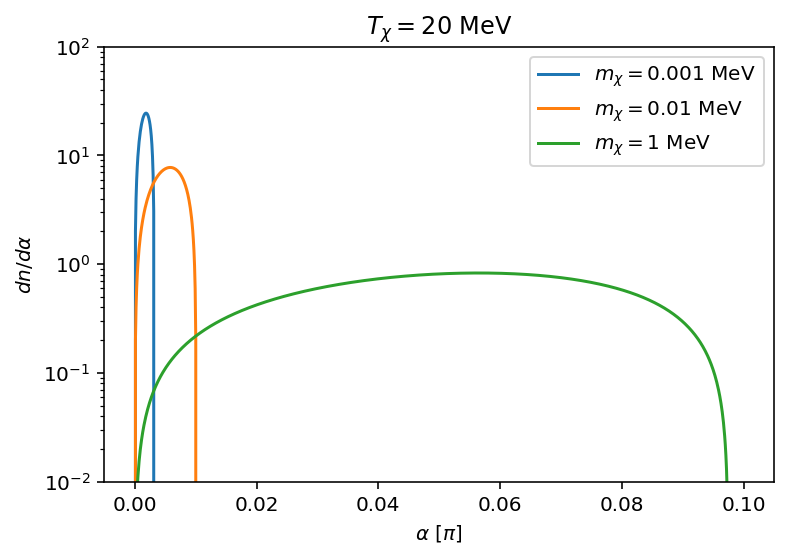

In [257]:
plt.plot(alpha_ls,g1,label='$m_\chi=$'+str(mx1)+' MeV')
plt.plot(alpha_ls,g2,label='$m_\chi=$'+str(mx2)+' MeV')
plt.plot(alpha_ls,g3,label='$m_\chi=$'+str(mx3)+' MeV')
plt.legend(loc='best')
plt.xlabel(r'$\alpha~[\pi]$')
plt.ylabel(r'$dn/d\alpha$')
plt.title('$T_\chi =$'+str(Tx)+' MeV')
plt.yscale('log')
plt.ylim(1e-2,100)
plt.savefig('ang_dist.pdf',facecolor='white')

In [41]:
mx_ls = np.logspace(-3,2,20)
g_int_ls = []
for mx in mx_ls:
    g_int_ls.append(quad(lambda a:2*np.pi*np.sin(a)*g(Ev(20,mx,a),1,a),0,0.5*np.pi)[0])

Text(0, 0.5, '$\\int g d\\Omega$')

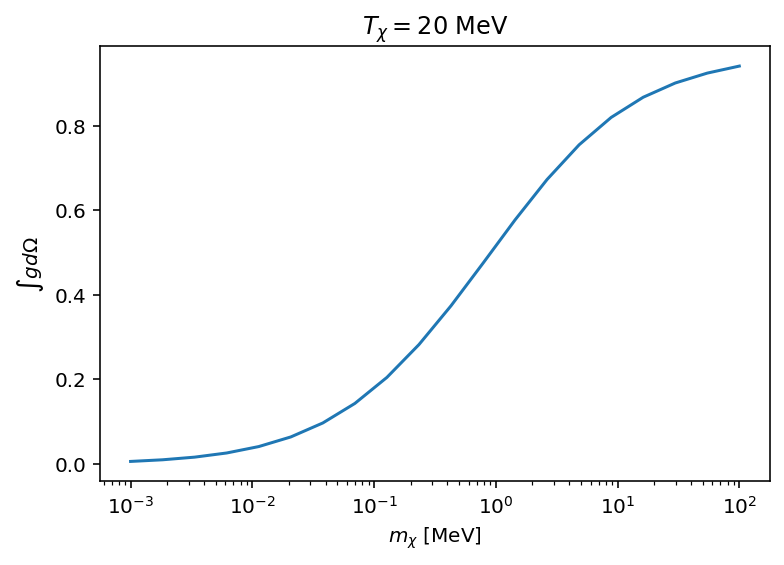

In [42]:
plt.plot(mx_ls,g_int_ls)
plt.xscale('log')
#plt.ylim(0,2)
plt.title(r'$T_\chi = 20$ MeV')
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$\int g d\Omega$')
#plt.savefig('int_g_fix_mx.png',dpi=300,bbox_inches='tight',facecolor='white')

## Boosted DM flux at Earth

The upscattered DM flux is given by
$$
\frac{d\Phi^{N}(T_{\chi},t)}{dT_{\chi}dt}=2\pi \mathcal{J}\tau\int_{\cos\theta_{{\rm min}}}^{\cos\theta_{{\rm max}}}d\cos\theta \left. j_{\chi}^{N}(r,T_{\chi},\alpha)\right|_{\frac{r}{c}+\frac{\ell}{v_{\chi}}=t}
$$
where $\theta \in [0,\pi/2]$ and $\mathcal{J}$ is a Jacobian.
Once $t$ is given, the corresponding $r$ is also known for specified $\ell$ and $\cos\theta$ where
$$
r=\sqrt{\ell^2+R^2-2\ell R \cos\theta}
$$
hence after solving
$$
\frac{r}{c}+\frac{\ell}{v_\chi}=t
$$
we have (I used *Mathematica*)
$$
\ell = \frac{-\sqrt{4 v_{\chi }^2 \left(c^2 t^2-R^2\right) \left(v_{\chi }^2-c^2\right)+v_{\chi }^2 \left(2 c^2 t-2 R \cos \theta  v_{\chi }\right){}^2}+2 c^2 t v_{\chi }-2 R \cos \theta  v_{\chi }^2}{2 \left(c^2-v_{\chi }^2\right)}.
$$
Note that $t$ consists of two parts. The first counts from the propagation time of SN neutrino from the explosion site to the upscattering point $r/c$ (assuming neutrino carries light speed). The second indicates the DM propagation time from the upscattering point to the Earth $\ell/v_\chi$.
In addition, the Jacobian factor is derived as
$$
d\left(\frac{r}{c}+\frac{\ell}{v_\chi}\right)=dt\to \left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)d\ell = dt,
$$
Thus,
$$
\mathcal{J}=\left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)^{-1}.
$$

Some input, such as $t$, have no physical solutions for both $\ell$ and $r$ (one or both of them would be negative). Therefore the contribution from such $t$ to the emissivity $j_\chi^N$ should be removed manually.

Another trouble happens when we use $\sin\alpha =R\sin\theta/r$ to obtain $\alpha$. The two cases are degenerate $\sin\alpha = \sin(\pi-\alpha)$. *Numpy* function `arcsin` only returns $\alpha<\pi/2$ result, despite sometimes the true $\alpha$ is larger than $\pi/2$. So instead of using the law of sine, I implemented the law of cosine which will return the true $\alpha$ even it is larger than $\pi/2$. 

Since $\ell$ and $r$ are known, we have
$$
\cos(\pi-\alpha)=\frac{r^2+\ell^2-R^2}{2r\ell}
$$
thus
$$
\alpha =\cos^{-1}\left(\frac{R^2-r^2-\ell^2}{2r\ell}\right).
$$
The above guarantees the true $\alpha$ can be faithfully revealed.

<div align="center"> <img src="./geometry.png"> </div>

### Simplified expression for $\ell$

We can have more simplified expression for $\ell$ with
$$
r + \frac{\ell}{v_\chi} = ct \equiv\zeta
$$
where $r$, $\ell$ and $\zeta$ are in kpc and $v_\chi$ is dimensionless velocity. Thus,
$$
\ell = \frac{-\sqrt{4 \left(\zeta ^2-R^2\right) \left(v_{\chi }^2-1\right) v_{\chi }^2+v_{\chi }^2 \left(2 \zeta -2 R \cos \theta  v_{\chi }\right){}^2}+2 R \cos \theta  v_{\chi }^2-2 \zeta  v_{\chi }}{2 \left(v_{\chi }^2-1\right)}.
$$
Note that $t$ is the total propagation time timing from the upscattering point.

### The longest time-of-arrival at Earth for a given $m_\chi$ and $T_\chi$

Given the upscattered DM kinetic energy $T_\chi$, it has an associated velocity 
$$
v_\chi= \frac{\sqrt{T_\chi(T_\chi+2m_\chi)}}{T_\chi + m_\chi}.
$$
Suppose the minimum upscattered position from the MW center is $r_0$, the total propagation distance is $R-r_0$ and the propagation time is $(R-r_0)/v_\chi$.
The time-of-arrival $t_{\rm toa}$ is measured after the first arrival of SN neutrino at Earth from the MW center that is $t_\nu=R/c$. Thus,
$$
t_{\rm toa} = \frac{R-r_0}{v_\chi} - t_\nu
$$

In [5]:
def find_lra(t,theta,vx,R=8.5,r_cut=0.001):
    """
    Find l, r and alpha when t, cos\theta, R and vx are given
    
    Input
    ------
    t: timing in seconds, 0 starts from the first arrival of the SN neutrino at Earth
    theta: in rad
    vx: dimensionless DM velocity, v/c
    R: R in kpc, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    tuple: (l,r,alpha,flag)
           flag is a string label, physical/unphysical, where unphysical
           result should be considered zero contribution to the emissivity
    """
    cos = np.cos(theta)
    zeta = c*t/kpc2cm + R
    
    l = (-2*zeta*vx+2*cos*R*vx**2 + np.sqrt(vx**2*(2*zeta-2*cos*R*vx)**2 + 4*(-R**2+zeta**2)*vx**2*(-1+vx**2)))/(2*(-1+vx**2))
    r = np.sqrt(l**2 + R**2 - 2*l*R*cos)
    alpha = np.arccos((R**2-r**2-l**2)/(2*r*l))
    
    # Some input, eg., t, will cause l or r is negative, this is not physical and
    # have no contribution to the emissivity.
    # I raise a flag to discrimate such situation and ask the program to set the
    # corresponding emissivity zero manually
    if l > 0 and r > r_cut and 0 <= alpha <= 0.5*np.pi:
        flag = 'physical'
    else:
        flag = 'unphysical'
    return l,r,alpha,flag

def bdmflux(t,Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,theta=1,r_cut=0.001):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 0.001 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    # find DM velocity
    vdm = vx(Tx,mx)
    
    # Define the BDM emissivity jx for integration 
    def jx_tot(th):
        #cos = np.cos(theta)
        l,r,alpha,flag = find_lra(t,th,vdm,R,r_cut)
        if flag == 'physical':
            jac = 1/((l - R*np.cos(th))/r + 1/vdm)
            return jac*sigxv*tau*xemissivity(Tx,mx,alpha,r,rho,rs,Lv)*np.sin(th)
        else:
            return 0
    return 2*np.pi*c*(quad(jx_tot,0,0.0001*np.pi)[0]+quad(jx_tot,0.0001*np.pi,0.001*np.pi)[0]+quad(jx_tot,0.001*np.pi,0.01*np.pi)[0]+quad(jx_tot,0.01*np.pi,0.1*np.pi)[0]
                          +quad(jx_tot,0.1*np.pi,0.2*np.pi)[0]
                          +quad(jx_tot,0.2*np.pi,0.3*np.pi)[0]
                          +quad(jx_tot,0.3*np.pi,0.4*np.pi)[0]
                          +quad(jx_tot,0.4*np.pi,0.5*np.pi)[0])

In [11]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx1 = 5
#Tx2 = 50

# years
yrls=np.logspace(-6,3,300)
#yrls1kev=np.logspace(-6,0,50)


fluxmx1_20=[]
for y in yrls:
    fluxmx1_20.append(bdmflux(y*yr,Tx1,mx1,r_cut=0.001))

fluxmx2_20=[]
for y in yrls:
    fluxmx2_20.append(bdmflux(y*yr,Tx1,mx2,r_cut=0.001))
    
fluxmx3_20=[]
for y in yrls:
    fluxmx3_20.append(bdmflux(y*yr,Tx1,mx3,r_cut=0.001))

fluxmx4_20=[]
for y in yrls:
    fluxmx4_20.append(bdmflux(y*yr,Tx1,mx4,r_cut=0.001))

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in arccos


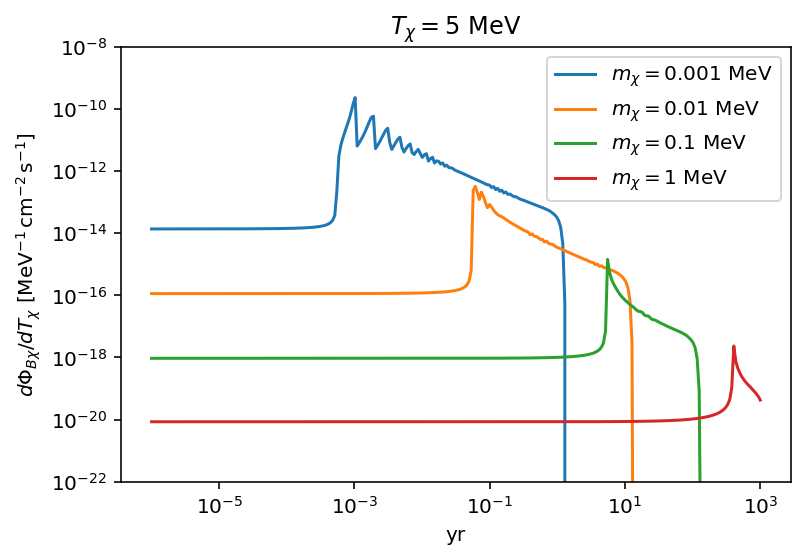

In [113]:
plt.plot(yrls,fluxmx1_20,label='$m_\chi=$'+str(mx1)+' MeV')
plt.plot(yrls,fluxmx2_20,label='$m_\chi=$' +str(mx2)+' MeV')
plt.plot(yrls,fluxmx3_20,label='$m_\chi=$' +str(mx3)+' MeV')
plt.plot(yrls,fluxmx4_20,label='$m_\chi=$' +str(mx4)+' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi_{B\chi}/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title(r'$T_\chi =$'+str(Tx1)+' MeV')
plt.legend(loc='best')
plt.ylim(1e-22,1e-8)
#plt.savefig('time_dependent_flux_20MeV_2.pdf',facecolor='white',bbox_inches='tight')
plt.show()

We can make an approximation that $dn/d\alpha=\delta(\alpha)$, this is generally true for $m_\chi \ll E_\nu$. By the identity $\delta(\alpha(\theta))=\delta(\theta)/|\alpha^\prime(0)|$ we have
$$
\alpha^\prime(\theta)=\frac{R}{r}\frac{\cos\theta}{\sqrt{1-\frac{R^2}{r^2}\sin^2\theta}}\to \alpha^\prime(0)=\frac{R}{r}
$$
and
$$
g(\alpha)=\frac{dn}{d\Omega}=\frac{1}{2\pi \sin\alpha}\frac{dn}{d\alpha}=\frac{\delta(\alpha)}{2\pi \sin\alpha}.
$$
Note that in the above derivation we used the law of sine $\sin\alpha = R\sin\theta/r$.

Thus, the BDM flux integration becomes
\begin{align*}
\frac{d\Phi_B(T_{\chi},t)}{dT_{\chi}dt} & =2\pi \mathcal{J}\tau \sigma_{\chi\nu}\int n_{\chi}(r)\frac{dn_{\nu}}{dE_{\nu}}g(\alpha,E_{\nu})\frac{dE_{\nu}}{dT_{\chi}}\sin\theta d\theta\\
 & =\mathcal{J}\tau \sigma_{\chi\nu}\int n_{\chi}(r)\frac{dn_{\nu}}{dE_{\nu}}\frac{r^{2}}{R^{2}}\delta(\theta)\frac{dE_{\nu}}{dT_{\chi}}d\theta\\
 & =\left.\frac{r^{2}}{R^{2}}\mathcal{J}\tau \sigma_{\chi\nu}n_{\chi}(r)\frac{dn_{\nu}}{dE_{\nu}}\frac{dE_{\nu}(\alpha=0)}{dT_{\chi}}\right|_{\frac{r}{c}+\frac{\ell}{v_{\chi}}=t}.
\end{align*}
Since this is single-direction approximation, it has $\ell = R-r$. Thus,
$$
r = \frac{R-v_\chi t}{1-v_\chi/c}
$$
and
$$
\mathcal{J} = \left(\frac{1}{c}-\frac{1}{v_\chi}\right)^{-1}.
$$
Note that $\mathcal{J}$ is negative but the original $\int_0^{\pi/2}d\cos\theta =-\int_0^{\pi/2}\sin\theta d\theta$ which cancels the minus sign in $\mathcal{J}$ and the whole result ramains positive.

In addition,
$$
E_\nu(\theta=0) = \frac{1}{2}(T_\chi+\sqrt{T_\chi(2m_\chi+T_\chi)})
$$
and
$$
\frac{dE_\nu}{dT_\chi}(\theta=0) = \frac{2m_\chi+3T_\chi+2\sqrt{T_\chi(2m_\chi+T_\chi)}}{4\sqrt{T_\chi(2m_\chi+T_\chi)}}
$$
Thus the total event rate would be
$$
N_{\rm BDM} = N_e \sigma_{\chi e} \int \frac{d\Phi_B}{dT_\chi dt} \frac{v_\chi/c}{1-v_\chi/c}dt dT_\chi
$$

In [7]:
def max_time(Tx,mx):
    vdm = vx(Tx,mx)*c
    t = (8.5)*kpc2cm/vdm - (8.5)*kpc2cm/c
    thirty_yr = 30*yr
    if True:#t <= thirty_yr:
        return t
    else: return thirty_yr 

def bdmflux_single(t,Tx,mx,sigxv=1e-45,tau=10,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=0.01):
    """
    Upscattered DM emissivity, note the returned result is divided by sigxv and light velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    vx: the DM dimensionless velocity in terms of Tx and mx
    r: the distance from the scattering point to GC, kpc
    rho: DM halo characteristic density, default 184 MeV/cm^3
    rs: DM halo characteristic length, default 24.42 kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    R: the distance between Earth and the GC SN, in kpc
    r_cut: the most inner DM region, in kpc
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """  
    vdm = vx(Tx,mx)
    tv = R*kpc2cm/c
    r = (R - vdm*c*(t+tv)/kpc2cm)/(1-vdm)
    
    if r >= r_cut:
        jac = 1/(1/vdm - 1)
        Enu = (Tx+np.sqrt(Tx*(2*mx + Tx)))/2
        dEdT = (2*mx+3*Tx+2*np.sqrt(Tx*(2*mx+Tx)))/4/np.sqrt(Tx*(2*mx+Tx))
        jx = c*tau*c*sigxv*dnvdEv(r,Enu,Lv)*dEdT*r**2/R**2*jac*(4488/mx) #nx(r,mx,rho,rs)
    else: jx = 0    
    return jx

In [12]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.1
mx4 = 1
Tx = 5

# years
#yrls=np.logspace(-6,2,1000)

fluxmx1_single=[]
for y in yrls:
    fluxmx1_single.append(bdmflux_single(y*yr,Tx,mx1))

fluxmx2_single=[]
for y in yrls:
    fluxmx2_single.append(bdmflux_single(y*yr,Tx,mx2))
    
fluxmx3_single=[]
for y in yrls:
    fluxmx3_single.append(bdmflux_single(y*yr,Tx,mx3))

fluxmx4_single=[]
for y in yrls:
    fluxmx4_single.append(bdmflux_single(y*yr,Tx,mx4))

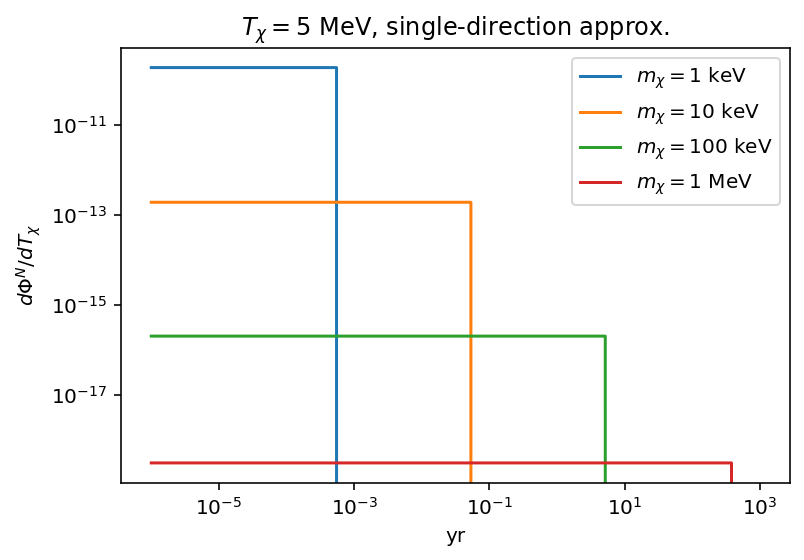

In [13]:
plt.plot(yrls,fluxmx1_single,label='$m_\chi=$' +str(int(1000*mx1)) +' keV')
plt.plot(yrls,fluxmx2_single,label='$m_\chi=$' +str(int(1000*mx2)) +' keV')
plt.plot(yrls,fluxmx3_single,label='$m_\chi=$' +str(int(1000*mx3)) +' keV')
plt.plot(yrls,fluxmx4_single,label='$m_\chi=$' +str(mx4) +' MeV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('yr')
plt.ylabel(r'$d\Phi^N/dT_\chi$')
plt.title(r'$T_\chi =$'+str(Tx)+r' MeV, single-direction approx.')
plt.legend(loc='best')
#plt.savefig('sigle_BDM_flux.pdf',facecolor='white',bbox_inches='tight')
plt.show()

Text(0.5, 1.0, '$T_\\chi =$5 MeV')

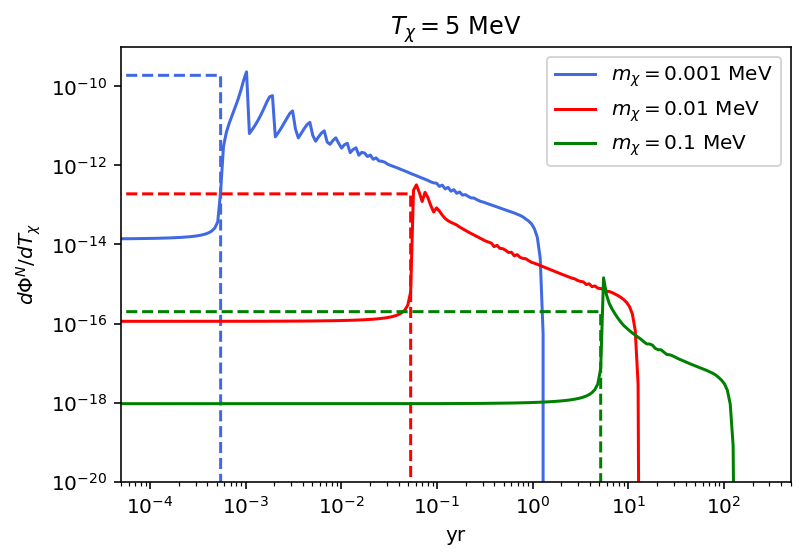

In [28]:
# comparison: single and multiple -directions 
plt.plot(yrls,fluxmx1_20,color='royalblue',label='$m_\chi=$' +str(mx1) +' MeV')
plt.plot(yrls,fluxmx1_single,'--',color='royalblue')
plt.plot(yrls,fluxmx2_20,color='red',label='$m_\chi=$' +str(mx2) +' MeV')
plt.plot(yrls,fluxmx2_single,'--',color='red')
plt.plot(yrls,fluxmx3_20,color='green',label='$m_\chi=$' +str(mx3) +' MeV')
plt.plot(yrls,fluxmx3_single,'--',color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.ylim(1e-20,1e-9)
plt.xlim(5e-5,500)
plt.xlabel('yr')
plt.ylabel(r'$d\Phi^N/dT_\chi$')
plt.title(r'$T_\chi =$'+str(Tx)+' MeV')
#plt.savefig('single_multiple.pdf')

In [31]:
fluxmx1_single[0]/fluxmx2_single[0]

995.2837998306512

In [33]:
fluxmx1_20[0]/fluxmx2_20[0]

120.56006883665114

In [62]:
min_Tx = 5
mx_ls = np.logspace(-6,np.log10(20),30)
event_ls = []
error_ls = []
for mx in mx_ls:
    max_t = max_time(min_Tx,mx)
    event,error = dblquad(lambda t,Tx: bdmflux_single(t,Tx,mx),min_Tx,100, lambda Tx: 0, lambda Tx: max_time(Tx,mx))
    event_ls.append(event)
    error_ls.append(error)

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


In [63]:
sigxv = 1e-35
sigxe = sigxv
sigxv_correction = sigxv/1e-45
detector_volume = 32
event_sk = np.asarray(event_ls)*3e32*detector_volume*sigxv_correction*sigxe

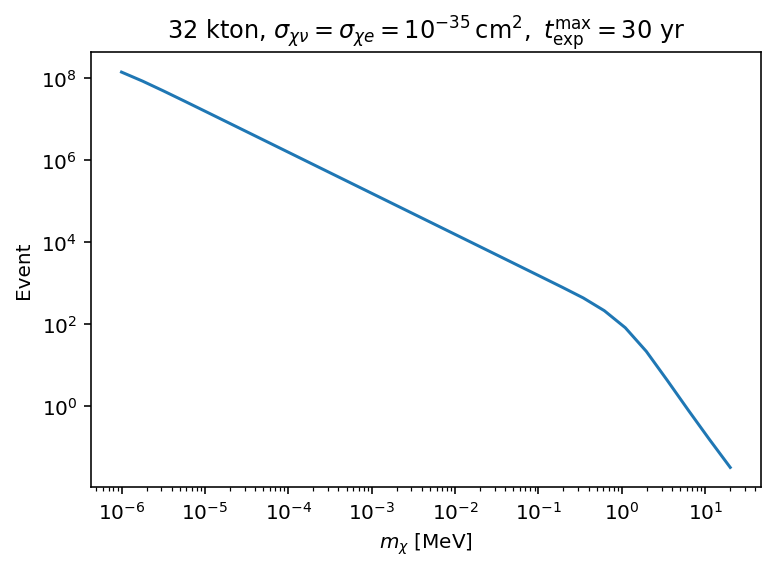

In [64]:
plt.plot(mx_ls,event_sk)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel('Event')
plt.title(r'32 kton, $\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-35}\,{\rm cm}^2,~t_{\rm exp}^{\rm max}=30$ yr')
#plt.savefig('event_rate.pdf',facecolor='white')
plt.show()

In [133]:
quad(lambda t: bdmflux_single(t,5,1), 0,max_time(5,1)) #single, mx=1MeV

(3.726495510408049e-09, 4.137241116817291e-23)

In [137]:
quad(lambda t: bdmflux(t,5,1), 0, 1400*yr) #multi, mx=0.1MeV

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


(8.699857414011084e-09, 1.075582116622876e-08)

In [11]:
quad(lambda t: bdmflux_single(t,5,0.1), 0,max_time(5,0.1)) #single, mx=0.1MeV

(3.357502272675396e-08, 3.727576328355515e-22)

In [12]:
quad(lambda t: bdmflux(t,5,0.1), 0, 130*yr) #multi, mx=0.1MeV

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


(8.665211765466222e-08, 5.7895921732381065e-09)

In [30]:
quad(lambda t: bdmflux_single(t,5,0.01), 0,max_time(5,0.01)) #single, mx=0.01MeV

(3.3199183389805967e-07, 3.6858497798115635e-21)

In [31]:
quad(lambda t: bdmflux(t,5,0.01), 0, 11*yr) #multi, mx=0.01MeV

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


(8.60413974537897e-07, 1.1567453993121794e-08)

In [122]:
quad(lambda t: bdmflux_single(t,5,0.001), 0,max_time(5,0.001)) #single, mx=0.001MeV

(3.3161548151337116e-06, 3.681671428983026e-20)

In [124]:
quad(lambda t: bdmflux(t,5,0.001), 0, 1.5*yr) #multi, mx=0.001MeV

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


(8.927054921589638e-06, 1.1693991597439276e-07)

In [158]:
quad(lambda t: bdmflux_single(t,5,0.0001), 0,max_time(5,0.0001)) #single, mx=0.0001MeV

(3.315776008287448e-05, 3.681250868900419e-19)

In [165]:
quad(lambda t: bdmflux(t,5,0.0001), 0, 0.14*yr) #multi, mx=0.0001MeV

/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/Users/yenhsun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


(8.557319502074385e-05, 1.2060630890449315e-05)

In [166]:
event_single = [3.726e-9,3.357e-8,3.319e-7,3.316e-6,3.315e-5]
event_multi = [8.699e-9,8.665e-8,8.604e-7,8.927e-6,8.557e-5]
mx_ls = [1,1e-1,1e-2,1e-3,1e-4]

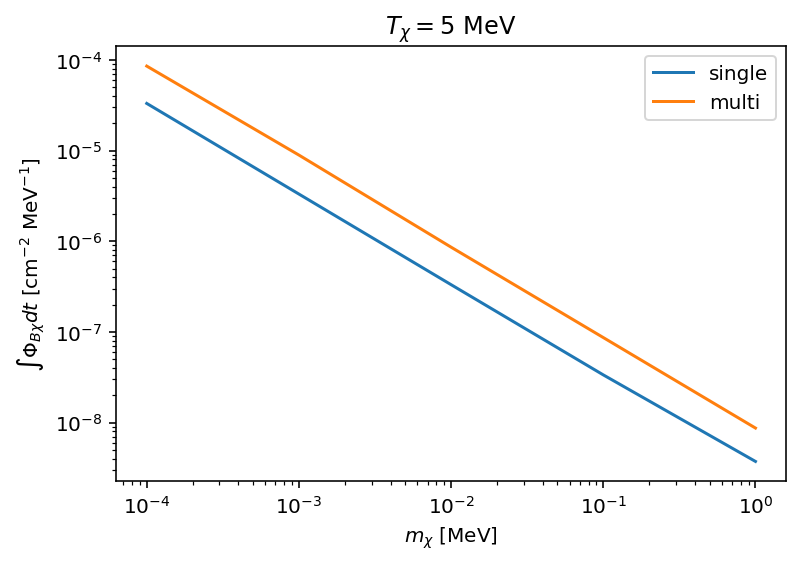

In [170]:
plt.plot(mx_ls,event_single, label='single')
plt.plot(mx_ls,event_multi, label='multi')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel(r'$\int \Phi_{B\chi} dt~{\rm [cm^{-2}~MeV^{-1}]}$')
plt.title(r'$T_\chi = 5$ MeV')
plt.legend()
plt.savefig('int_flux_over_time.png',bbox_inches='tight',facecolor='white')

In [74]:
np.sqrt(5*(2*0.01+5))/(5+0.01)

0.9999980079740798

In [77]:
vx(5,0.001)

0.9999999800079973

In [50]:
quad(lambda r:nx(r,1),0.001,8.5)[0]/8.5

4488.534954557107

In [39]:
time_ls = np.logspace(0,12,100)
l_ls = []
for t in time_ls:
    l,_,_,flag = find_lra(t,0.1*np.pi,vx(5,1),R=8.5,r_cut=0)
    if flag == 'physical':
        l_ls.append(l)
    else:
        l_ls.append(0)

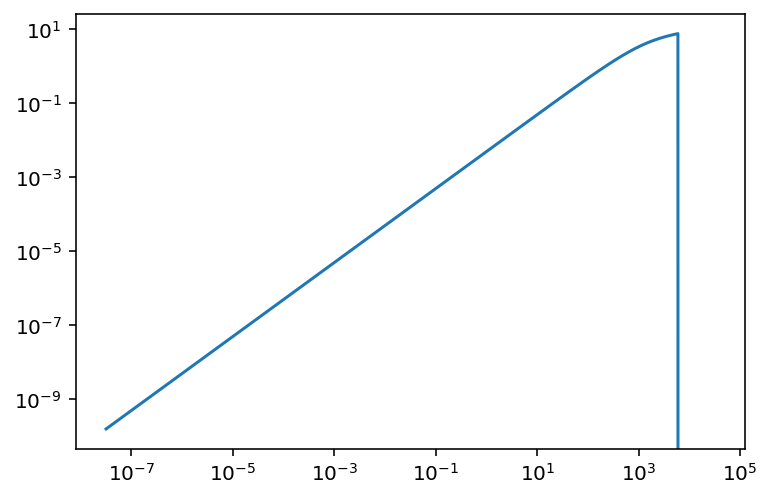

In [40]:
plt.plot(time_ls/yr,l_ls)
plt.xscale('log')
plt.yscale('log')

In [73]:
find_lra(2.387e+11,0.1*np.pi,vx(5,1),r_cut=0)

(8.083687569086274, 2.6266444685088692, 1.5706848463769534, 'physical')

In [45]:
np.pi/2

1.5707963267948966

In [56]:
2.35e+11-8.5*kpc2cm/c

-637666666666.6666

In [63]:
(l*kpc2cm/c+r*kpc2cm/vx(5,1)/c) - 8.5*kpc2cm/c

227105170519.0658

In [64]:
8.5/np.sqrt(1+vx(5,1)**2)

6.052586456788652

In [76]:
8.5*np.cos(0.1*np.pi)

8.083980388508804

In [98]:
thM=np.arctan(vx(5,1))

In [99]:
(8.5*kpc2cm/c*(np.sin(thM)+np.cos(thM)/vx(5,1))-8.5*kpc2cm/c)/yr

11740.68915229012

In [92]:
vx(5,0.01)

0.9999980079740798

In [91]:
np.sin(thM)+np.cos(thM)

1.4142135623723937

In [94]:
8.5*kpc2cm/c*0.4

349066666666.6667

In [95]:
yr

31536000

In [106]:
g(20,0.001,0.45*np.pi)

5.232004520157158e-06